In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import pandas as pd
from tqdm import tqdm

from scipy.stats import multivariate_normal, invwishart, matrix_normal

!pip install mplsoccer
from mplsoccer.pitch import Pitch

!pip install kloppy
from kloppy import metrica

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 KB 5.0 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.7/153.7 KB 18.2 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
def plot_latent_state_dynamic(X1, X2, A, b, show_fixed_point = False, show_states = False, z = None):
    ###
    # plot vector fields given by A_k and b_k in the observation space
    ###
    
    # fixed points of the linear dynamics
    y_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])

    n = X1.shape[0]
    X = np.stack([X1, X2])
    
    U = np.zeros((K, n, n))
    V = np.zeros((K, n, n))
    
    for k in range(K):
        for i in range(n):
            for j in range(n):
                U[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[0] + b[k, 0] - X[0, i, j]
                V[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[1] + b[k, 1] - X[1, i, j]
    
    fig, ax = plt.subplots(nrows = K, ncols = 1, figsize = (10, 8*K))
    colors = ["g", "b", "r", "c", "m"]

    for k in range(K):
        ax[k].quiver(X1, X2, U[k], V[k], width = 0.0025)
        ax[k].set_xlabel(r"$y_1$", fontsize = 15)
        ax[k].set_ylabel(r"$y_2$", fontsize = 15)
        ax[k].set_title(r"LDS with $k = {}$".format(k+1), fontsize = 15)
        
        if show_fixed_point:
            ax[k].scatter(y_star[k][0], y_star[k][1], label = 'fixed point')

        if show_states:
            #c = ["g" if i == 0 else "b" if i ==1 else "r" if i ==2 else "c" if i == 3 else "m" if i == 4 else i for i in z]
            c = [colors[k] if i == k else "grey" for i in z]
            #ax[k].scatter(y[:, 0], y[:, 1], color = c, s = 5)

            for t in range(T-1):
                ax[k].plot(y[t:t+2, 0], y[t:t+2, 1], c = c[t], lw = 0.5)
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = c[t])
        
        ax[k].legend(loc = 'upper left')

In [3]:
# function to transform values in [0,1] in values in [-1,1]
def normalize_coordinates(y):
    y1_norm = ((y[:, 0] - 0.5)*2).reshape(-1, 1)
    y2_norm = (-(y[:, 1] - 0.5)*2).reshape(-1, 1)
    y_norm = np.concatenate([y1_norm, y2_norm], axis = 1)
    return y_norm

## Collecting data

In [4]:
dataset = pd.read_csv("Datasets/match1.csv")
dataset_1 = dataset.where(dataset.period_id == 1) # select only first half of the match
#dataset_1 = dataset_1.fillna(0)

dataset_1

,Unnamed: 0,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,home_11_x,...,home_13_d,home_13_s,away_28_x,away_28_y,away_28_d,away_28_s,home_14_x,home_14_y,home_14_d,home_14_s
0,0.0,1.0,0.0,1.0,NaN,NaN,0.45472,0.61291,NaN,0.00082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.2,6.0,NaN,NaN,0.55677,0.61091,NaN,0.00140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.0,0.4,11.0,NaN,NaN,0.56504,0.69395,NaN,0.00085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,0.6,16.0,NaN,NaN,0.57330,0.77700,NaN,0.00065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1.0,0.8,21.0,NaN,NaN,0.57247,0.79726,NaN,0.00066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# create matrix of position data for all 11 players of home team

player = "home_" + str(1) # terzino sinistro
fh = dataset_1[[player + "_x", player + "_y"]].to_numpy()
fh = fh[np.isnan(fh) == False].reshape(-1, 2)
y = normalize_coordinates(fh)
n_timesteps = y.shape[0]

for i in range(1, 11):
    player = "home_" + str(i+1) # terzino sinistro
    fh = dataset_1[[player + "_x", player + "_y"]].to_numpy()
    fh = fh[np.isnan(fh) == False].reshape(-1, 2)

    if fh.shape[0] < n_timesteps:
        y = y[:fh.shape[0]]
        n_timesteps = fh.shape[0]
    else:
        fh = fh[:n_timesteps]
    
    fh = normalize_coordinates(fh)
    y = np.concatenate([y, fh], axis = 1)    

print(y.shape)

downsampling = 5 # how often data is taken from the trajectory (to reduce number of points)
y = y[::downsampling]
print(y.shape)

(9342, 22)
(1869, 22)


In [6]:
print(y)

[[-3.4704e-01  3.0644e-01 -3.2598e-01 ... -1.3462e-01 -9.9836e-01
  -3.5240e-02]
 [-3.5228e-01  2.4436e-01 -3.3470e-01 ... -2.1558e-01 -9.9872e-01
  -3.7360e-02]
 [-3.6258e-01  1.6626e-01 -3.4566e-01 ... -2.6936e-01 -1.0004e+00
  -3.9480e-02]
 ...
 [-3.0600e-03  9.7292e-01  5.2200e-02 ...  8.8542e-01 -6.2780e-01
   1.3040e-02]
 [-4.7000e-03  9.7264e-01  2.4020e-02 ...  8.8966e-01 -6.3628e-01
   6.1800e-03]
 [-6.3400e-03  9.7234e-01 -4.0000e-04 ...  8.7116e-01 -6.4634e-01
   1.1200e-03]]


In [7]:
# compute barycenter of the team

avg_y1 = np.mean(y[:, ::2], axis = 1).reshape(-1, 1)
avg_y2 = np.mean(y[:, 1::2], axis = 1).reshape(-1, 1)
print(avg_y1.shape)
print(avg_y2.shape)
avg_y = np.concatenate([avg_y1, avg_y2], axis = 1)
print(avg_y)

(1869, 1)
(1869, 1)
[[-0.26410909 -0.13705636]
 [-0.26535636 -0.19556364]
 [-0.27302182 -0.25009091]
 ...
 [ 0.10677636  0.57077455]
 [ 0.08644727  0.57211636]
 [ 0.06751636  0.57025818]]


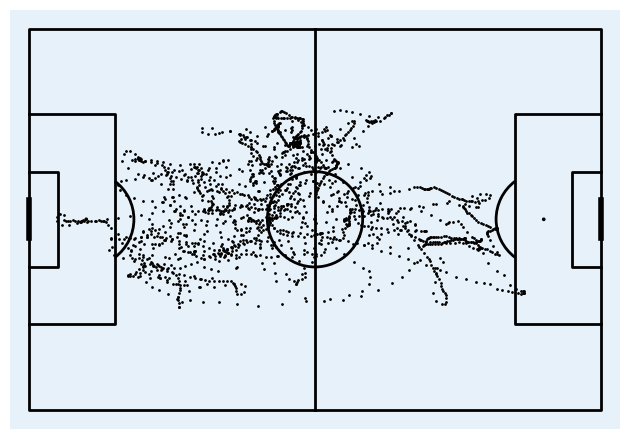

In [8]:
pitch = Pitch(pitch_color='#e7f1fa', line_zorder=1, line_color='black', pitch_type="statsbomb")
fig, ax = pitch.draw()
pitch.scatter((avg_y[:,0]+1)*60, (-avg_y[:,1]+1)*40, c='orange', s=1, ec='k', ax=ax)

(-1.0, 1.0)

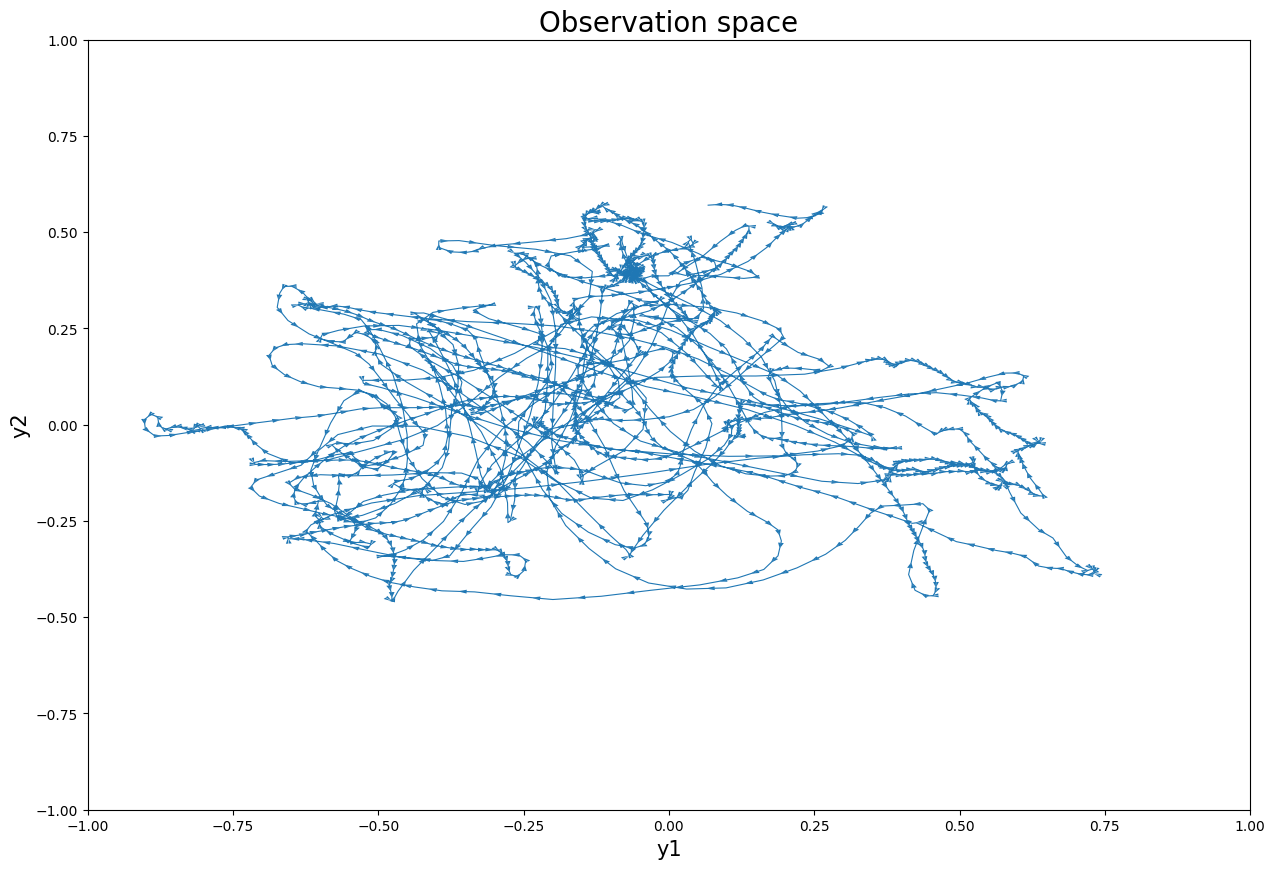

In [9]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(avg_y[:, 0], avg_y[:, 1], lw = 0.8)

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(avg_y.shape[0]-1):
    arr_mean_y1 = np.mean([avg_y[t, 0], avg_y[t+1, 0]])
    arr_mean_y2 = np.mean([avg_y[t, 1], avg_y[t+1, 1]])
    dy1 = avg_y[t+1, 0] - avg_y[t, 0]
    dy2 = avg_y[t+1, 1] - avg_y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01)
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("Observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [10]:
y = avg_y # TO GO BACK OF THE USUAL NOTATION

## Inference

In [11]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [12]:
T = y.shape[0] # number of time steps
N = 2 # observation dim
K = 5 # latent dim

L = 100 # how many Gibbs iteration to do

### PRIORS

# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

S = np.array([1/120, 1/80])*np.eye(N, N)
nu = N

C = np.zeros((N, N+1))
C[:, 0] = np.zeros(N)
C[:, 1:] = np.eye(N, N)
V = 1*np.eye(N+1, N+1)

### INFERRED VARIABLES

# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])

# inferred samples of A_hat
A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0][:, :, 0] = 1*np.random.randn(K, N)
A_hat_inf[0][:, :, 1:] = 1*np.random.randn(K, N, N)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([np.array([1/120, 1/80])*np.eye(N, N) for k in range(K)])

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

In [13]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


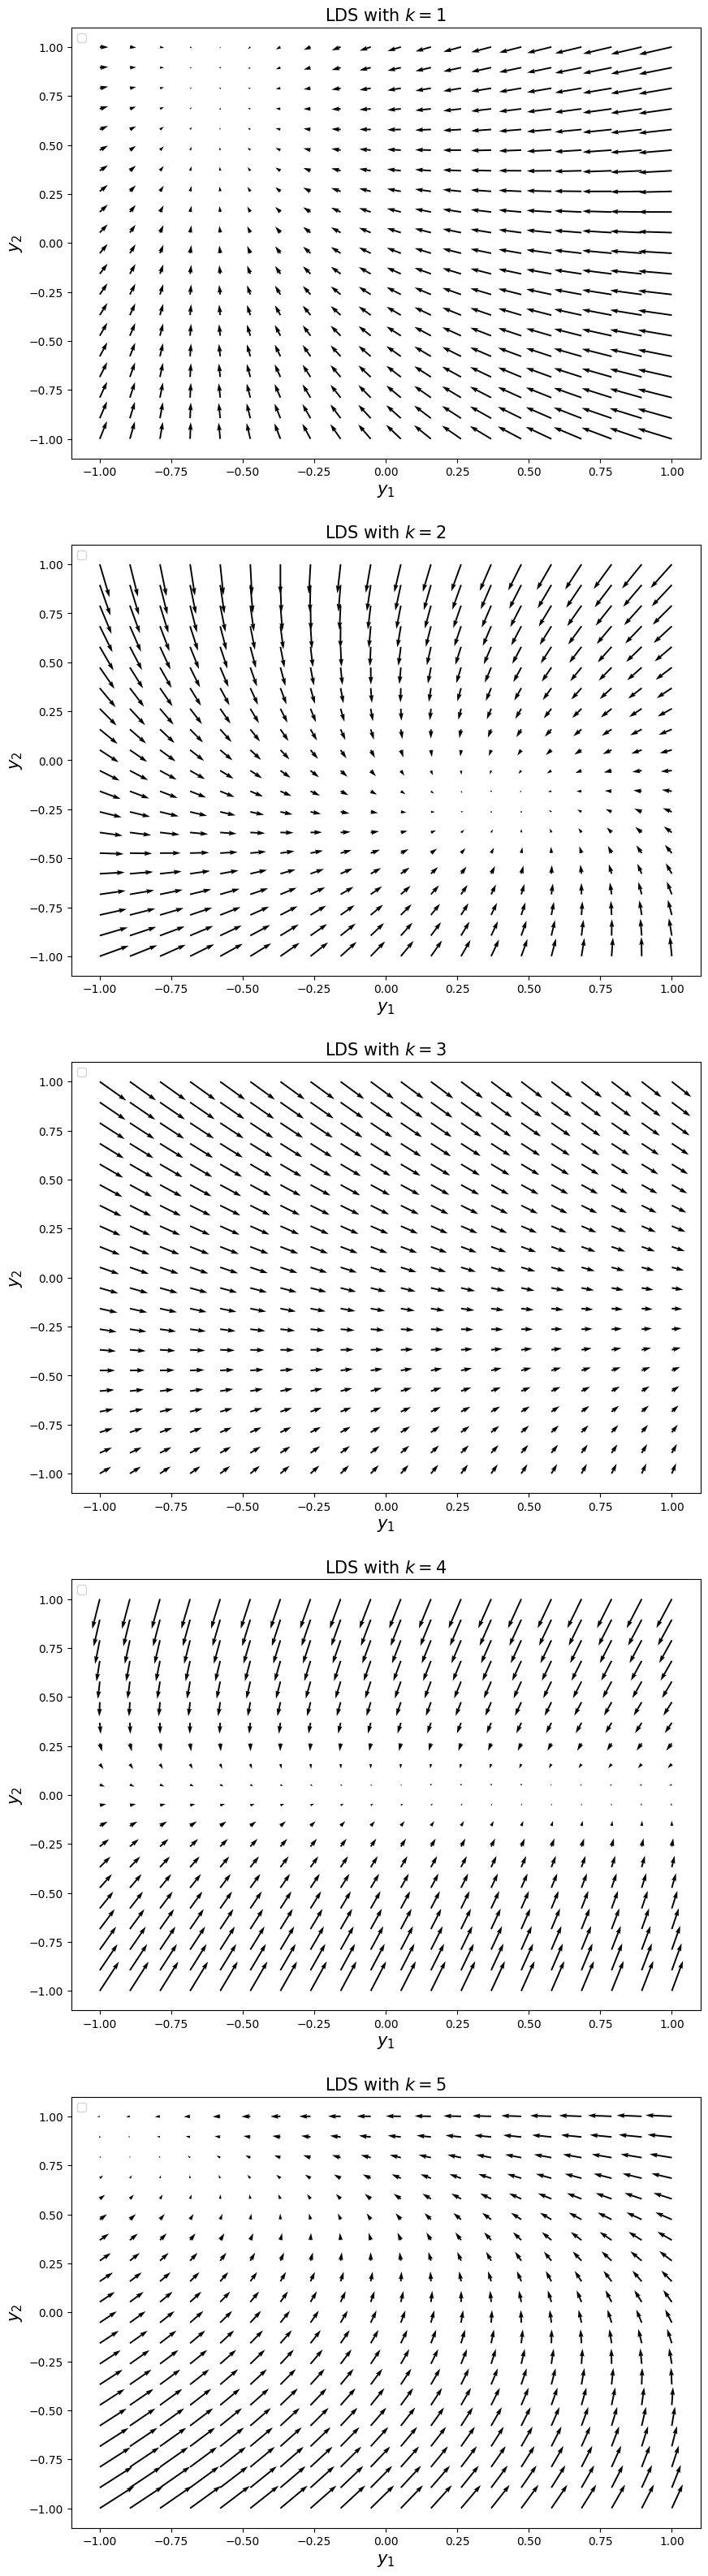

In [14]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf, b_inf, show_fixed_point = False)

In [15]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):

    log_m = [np.array([0]*K)] # list of log messages, the first one has all zeros

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]

            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # insert message in the list

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [16]:
### my version of sampling z_t

def myconditionals(M_inf_l, A_hat_inf_l, Q_inf_l, z_inf_prec):

    # discrete conditional distribution P(z_t|...) at each time 1,...,T
    p_z = np.zeros((T, K))
    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    # P(z_1|...)
    for k in range(K):
        log_p_z[0, k] = np.log(M_inf_l[z_inf_prec[1], k])
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    # P(z_t|...) for t in 2:T-1
    for t in range(1, T-1):
        for k in range(K):
            y_hat = np.concatenate([np.array([1]), y[t-1]])
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = rv.logpdf(x) + np.log(M_inf_l[z_inf_prec[t+1], k] * M_inf_l[k, z_inf_l[t-1]])
            #print(rv.pdf(x))

        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    # P(z_T|...)        
    for k in range(K):
        y_hat = np.concatenate([np.array([1]), y[T-2]])
        rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
        x = y[T-1] - np.dot(A_hat_inf_l[k], y_hat)
        log_p_z[T-1, k] = rv.logpdf(x) + np.log(M_inf_l[k, z_inf_l[T-2]])
    log_p_z[T-1] = log_p_z[T-1] - logsumexp(log_p_z[T-1])
    z_inf_l[T-1] = np.random.choice(K, p = np.exp(log_p_z[T-1]))

    return z_inf_l


In [17]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in tqdm(range(L-1)):
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)

100%|██████████| 99/99 [22:36<00:00, 13.70s/it]


In [18]:
def compute_mean_z(inferred_z):
    # mean_z of a certain number of samples, following majority rule
    mean_z = np.zeros(T).astype('int')
    for t in range(T):
        mean_z[t] = np.argmax(np.bincount(inferred_z[:, t]))
    return mean_z

In [19]:
# analysing inferred z at different epochs of the gibbs sampler
z_mean = compute_mean_z(z_inf[L//2:])
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(z_mean)

unique, counts = np.unique(z_inf[L//2:], return_counts=True)
print(dict(zip(unique, counts)))

[2 4 3 ... 0 4 2]
[2 3 3 ... 4 4 4]
[3 2 2 ... 3 3 3]
[2 2 2 ... 3 3 3]
{0: 13355, 1: 10840, 2: 10525, 3: 22990, 4: 35740}


In [20]:
M_mean = np.mean(M_inf[L//2:], axis = 0) # best estimate for M
print(M_mean)
eigw_inf, eigv_inf = np.linalg.eig(M_mean.T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0])) # stationary distribution of Prob(z)

[[0.8422938  0.03523669 0.01548574 0.06005463 0.04692914]
 [0.01095275 0.84945521 0.03974046 0.03874802 0.06110356]
 [0.02143396 0.01555907 0.83635744 0.12177825 0.00487128]
 [0.04213209 0.02691889 0.03557417 0.85009265 0.0452822 ]
 [0.02244945 0.01380679 0.00718671 0.02750489 0.92905215]]
[0.14336071 0.12385033 0.11415303 0.24984352 0.36879241]


In [21]:
A_hat_mean = np.mean(A_hat_inf[L//2:], axis = 0) # best estimate for A_hat
print(A_hat_mean)

[[[-3.14461587e-03  1.00104313e+00  2.37654697e-02]
  [ 4.11398534e-02 -9.45459084e-03  9.54056862e-01]]

 [[ 3.75522026e-02  9.99309324e-01  7.31897466e-03]
  [-2.36245329e-02 -5.32370910e-03  9.83332758e-01]]

 [[-3.67513244e-02  9.98351463e-01  2.23339662e-02]
  [-2.77598880e-02 -3.27326076e-03  9.71309104e-01]]

 [[-1.51515863e-02  9.87699095e-01 -8.22065619e-03]
  [ 4.07734463e-03  3.00391212e-03  1.00169070e+00]]

 [[ 1.07425318e-02  9.84198856e-01 -1.81798785e-02]
  [-9.96978127e-05 -7.73169136e-04  9.97175646e-01]]]


In [22]:
Q_mean = np.mean(Q_inf, axis = 0) # best estimate for Q
for k in range(K):
    print(Q_mean[k])
    eigw_q, _ = np.linalg.eig(Q_mean[k]) # eigenvalues of Q_k
    print(eigw_q, "\n")

[[ 8.43167259e-04 -7.97418064e-05]
 [-7.97418064e-05  4.83244822e-04]]
[0.00086004 0.00046637] 

[[0.00090031 0.0001415 ]
 [0.0001415  0.00054876]]
[0.00095019 0.00049888] 

[[ 0.00052058 -0.00015018]
 [-0.00015018  0.00092078]]
[0.00047049 0.00097087] 

[[3.13470359e-04 2.52162673e-05]
 [2.52162673e-05 3.22095120e-04]]
[0.0002922  0.00034337] 

[[1.50438283e-04 8.71970600e-07]
 [8.71970600e-07 2.06962115e-04]]
[0.00015042 0.00020698] 



In [23]:
# best estimate for A_hat decomposition in A and b, in order to plot the lds
b_inf_av = A_hat_mean[:,:,0]
A_inf_av = A_hat_mean[:,:,1:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


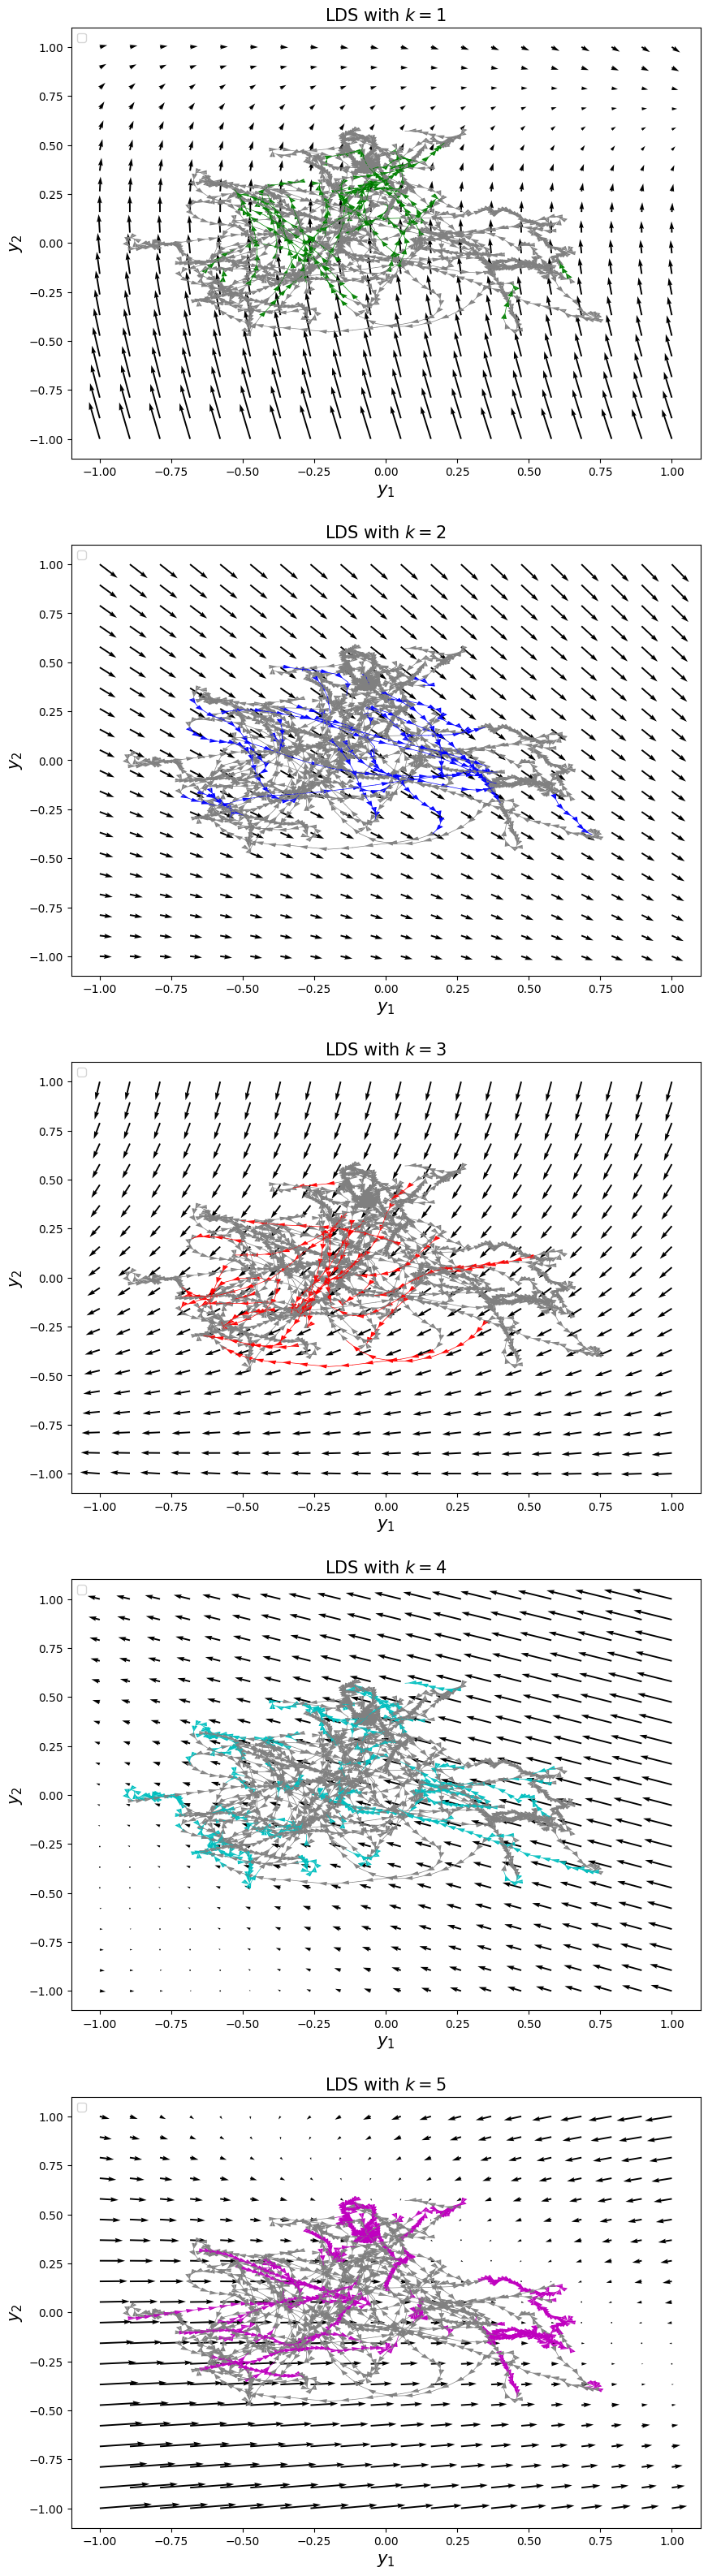

In [24]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf_av, b_inf_av, show_fixed_point = False, show_states = True, z = z_mean)

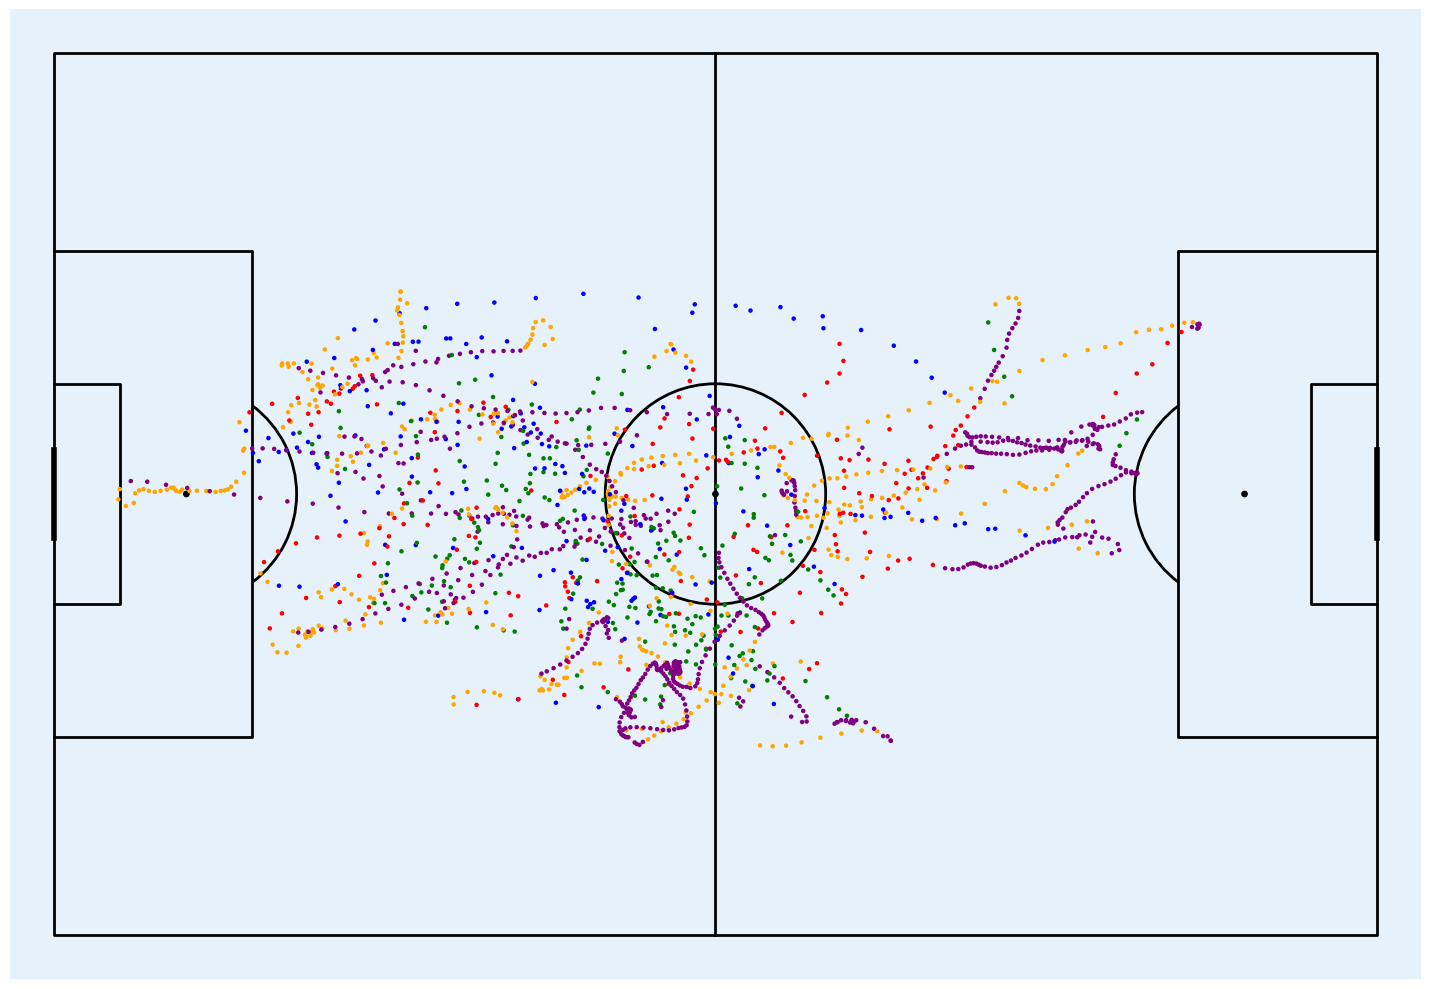

In [25]:
from mplsoccer.pitch import Pitch
c = ["green" if i == 0 else "blue" if i ==2 else "red" if i ==1 else "orange" if i ==3 else "purple"  for i in z_mean]
pitch = Pitch(pitch_color='#e7f1fa', line_zorder=1, line_color='black', pitch_type="statsbomb")
fig, ax = pitch.draw()
pitch.scatter((y[:,0]+1)*60, (y[:,1]+1)*40, s=5, ax=ax,c=c)

In [26]:
events = pd.read_csv("./Datasets/Sample_Game_1_RawEventsData.csv")

events = events[events["Period"]==1]
events = events[events["Team"]=="Home"].reset_index(drop=True)
events['state'] = None
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,state
0,Home,RECOVERY,INTERCEPTION,1,378,15.12,378,15.12,Player2,NaN,0.27,0.78,NaN,NaN,None
1,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,Player2,NaN,0.27,0.78,0.59,0.64,None
2,Home,CHALLENGE,AERIAL-WON,1,498,19.92,498,19.92,Player2,NaN,0.36,0.67,NaN,NaN,None
3,Home,RECOVERY,INTERCEPTION,1,498,19.92,498,19.92,Player2,NaN,0.36,0.67,NaN,NaN,None
4,Home,PASS,HEAD,1,498,19.92,536,21.44,Player2,Player9,0.36,0.67,0.53,0.59,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,Home,PASS,NaN,1,69225,2769.00,69260,2770.40,Player10,Player8,0.79,0.35,0.91,0.19,None
448,Home,BALL LOST,CROSS-INTERCEPTION,1,69260,2770.40,69268,2770.72,Player8,NaN,0.91,0.19,0.92,0.34,None
449,Home,RECOVERY,NaN,1,70460,2818.40,70460,2818.40,Player11,NaN,0.04,0.47,NaN,NaN,None
450,Home,PASS,GOAL KICK,1,70460,2818.40,70512,2820.48,Player11,Player7,0.04,0.47,0.15,0.88,None


In [27]:
for event in tqdm(range(len(events))):
    frame = events.iloc[(event)]["Start Time [s]"]
    pos = round(frame*5/downsampling)
    if pos < len(z_mean):
        events.at[event,'state'] =  int(z_mean[pos])


100%|██████████| 452/452 [00:00<00:00, 5940.68it/s]


In [28]:
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,state
0,Home,RECOVERY,INTERCEPTION,1,378,15.12,378,15.12,Player2,NaN,0.27,0.78,NaN,NaN,3
1,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,Player2,NaN,0.27,0.78,0.59,0.64,3
2,Home,CHALLENGE,AERIAL-WON,1,498,19.92,498,19.92,Player2,NaN,0.36,0.67,NaN,NaN,1
3,Home,RECOVERY,INTERCEPTION,1,498,19.92,498,19.92,Player2,NaN,0.36,0.67,NaN,NaN,1
4,Home,PASS,HEAD,1,498,19.92,536,21.44,Player2,Player9,0.36,0.67,0.53,0.59,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,Home,PASS,NaN,1,69225,2769.00,69260,2770.40,Player10,Player8,0.79,0.35,0.91,0.19,None
448,Home,BALL LOST,CROSS-INTERCEPTION,1,69260,2770.40,69268,2770.72,Player8,NaN,0.91,0.19,0.92,0.34,None
449,Home,RECOVERY,NaN,1,70460,2818.40,70460,2818.40,Player11,NaN,0.04,0.47,NaN,NaN,None
450,Home,PASS,GOAL KICK,1,70460,2818.40,70512,2820.48,Player11,Player7,0.04,0.47,0.15,0.88,None


{'PASS': 0.34686346863468637, 'BALL LOST': 0.19557195571955718, 'RECOVERY': 0.1881918819188192, 'CHALLENGE': 0.12915129151291513, 'SET PIECE': 0.07380073800738007, 'BALL OUT': 0.02952029520295203, 'SHOT': 0.02214022140221402, 'FAULT RECEIVED': 0.014760147601476014}


<AxesSubplot: title={'center': 'Total events in the considered time window'}>

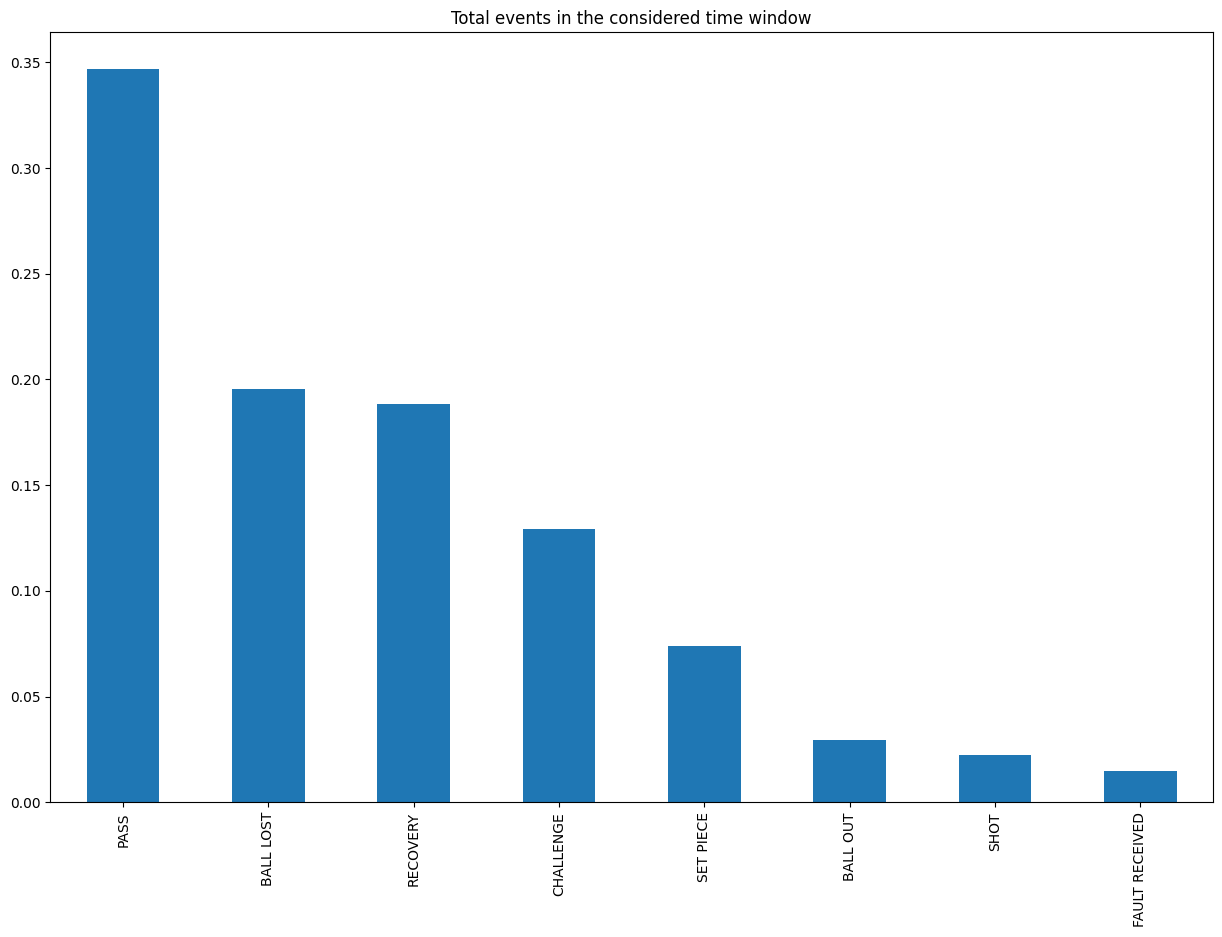

In [54]:
freq_events = events[events["Start Time [s]"] < len(z_mean)]["Type"].value_counts(normalize = True).to_dict()
print(freq_events)
event_types = list(freq_events.keys())
events[events["Start Time [s]"] < len(z_mean)]["Type"].value_counts(normalize = True).plot.bar(title = "Total events in the considered time window")

In [50]:
print(event_types)
print(expected_freq)

['PASS', 'BALL LOST', 'RECOVERY', 'CHALLENGE', 'SET PIECE', 'BALL OUT', 'SHOT', 'FAULT RECEIVED']
<built-in method values of dict object at 0x7f7ac21d3740>


{'PASS': 0.35555555555555557, 'BALL LOST': 0.24444444444444444, 'CHALLENGE': 0.17777777777777778, 'RECOVERY': 0.13333333333333333, 'FAULT RECEIVED': 0.044444444444444446, 'SET PIECE': 0.022222222222222223, 'BALL OUT': 0.022222222222222223}


<AxesSubplot: >

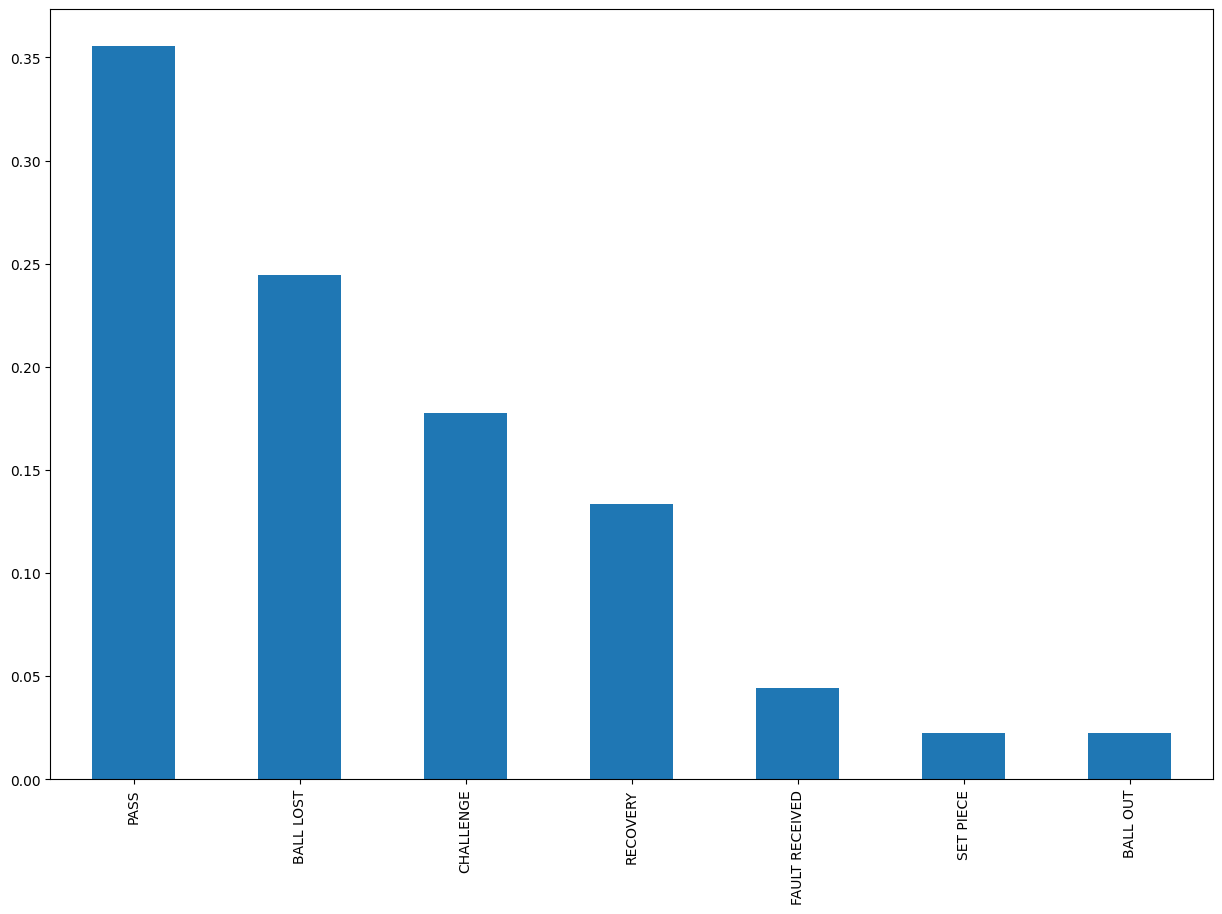

In [55]:
freq_events_0 = events[events["state"]==0]["Type"].value_counts(normalize = True).to_dict()
print(freq_events_0)
events[events["state"]==0]["Type"].value_counts(normalize = True).plot.bar()

In [ ]:
for event in event_types:
    print()

BALL LOST    18
PASS         18
RECOVERY      9
CHALLENGE     6
SHOT          2
BALL OUT      1
Name: Type, dtype: int64


<AxesSubplot: >

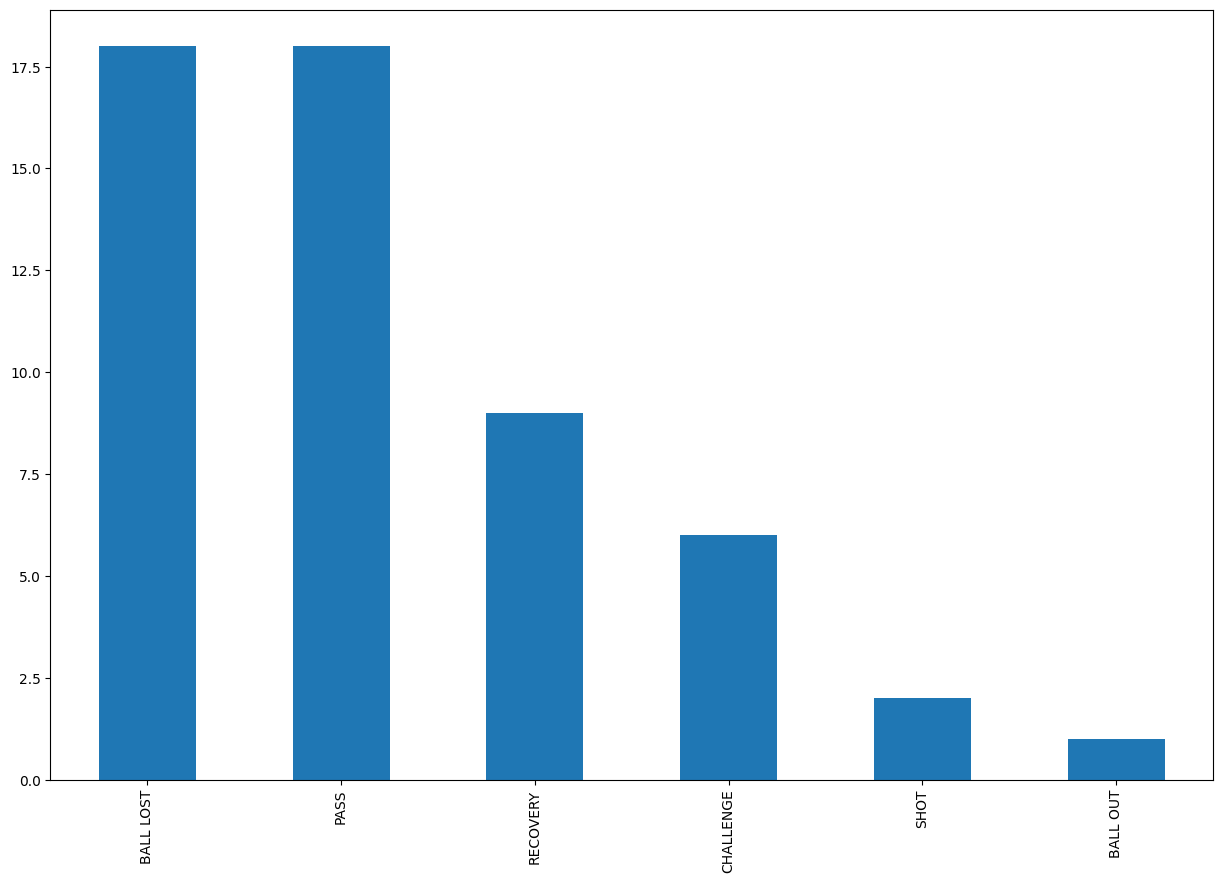

In [31]:
freq_events_1 = events[events["state"]==1]["Type"].value_counts()
print(freq_events_1)
events[events["state"]==1]["Type"].value_counts().plot.bar()

RECOVERY          13
PASS               9
CHALLENGE          7
BALL OUT           3
BALL LOST          2
FAULT RECEIVED     1
Name: Type, dtype: int64


<AxesSubplot: >

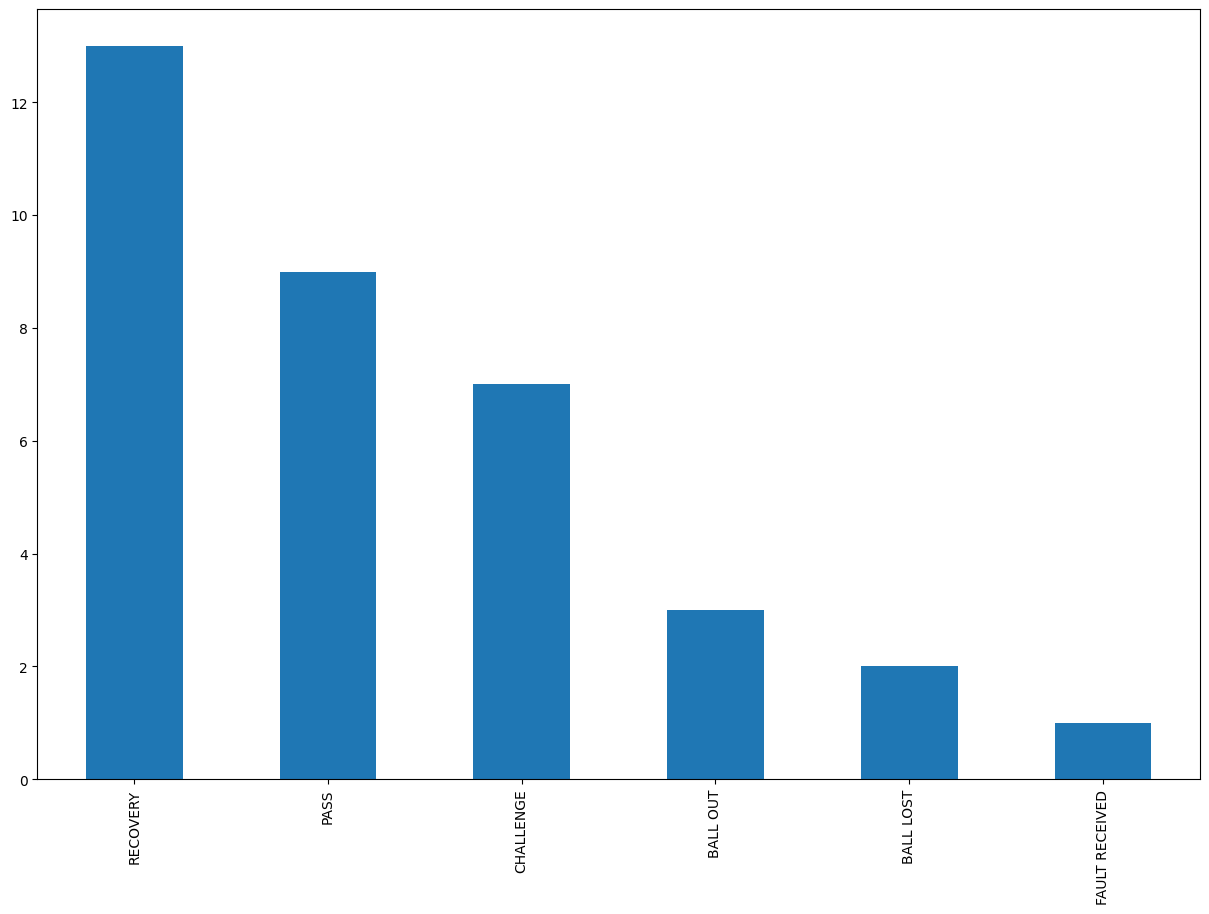

In [32]:
freq_events_2 = events[events["state"]==2]["Type"].value_counts()
print(freq_events_2)
events[events["state"]==2]["Type"].value_counts().plot.bar()

PASS              28
RECOVERY          16
BALL LOST         13
CHALLENGE          9
SET PIECE          6
BALL OUT           2
FAULT RECEIVED     1
Name: Type, dtype: int64


<AxesSubplot: >

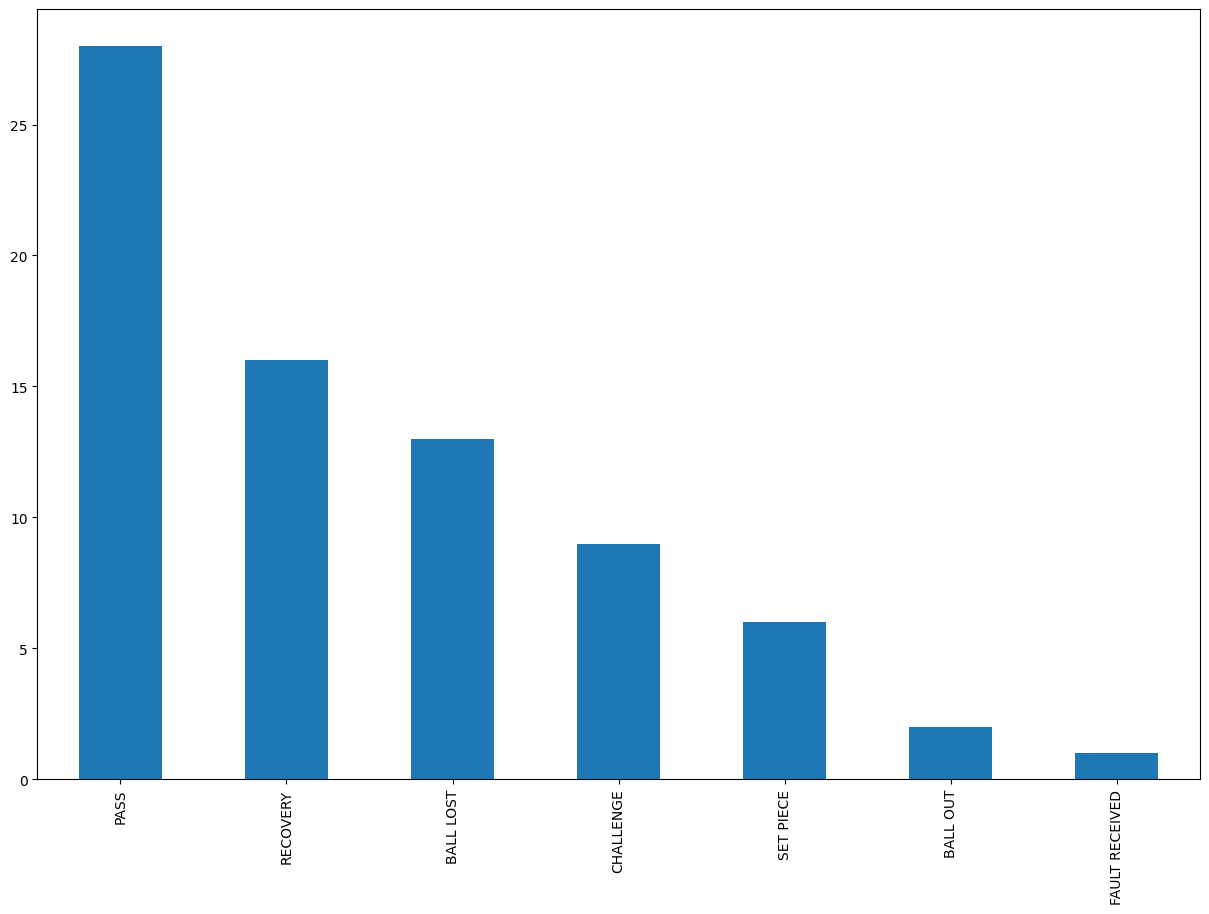

In [33]:
freq_events_3 = events[events["state"]==3]["Type"].value_counts()
print(freq_events_3)
events[events["state"]==3]["Type"].value_counts().plot.bar()

PASS         23
SET PIECE    13
BALL LOST     9
RECOVERY      7
CHALLENGE     5
SHOT          4
BALL OUT      1
Name: Type, dtype: int64


<AxesSubplot: >

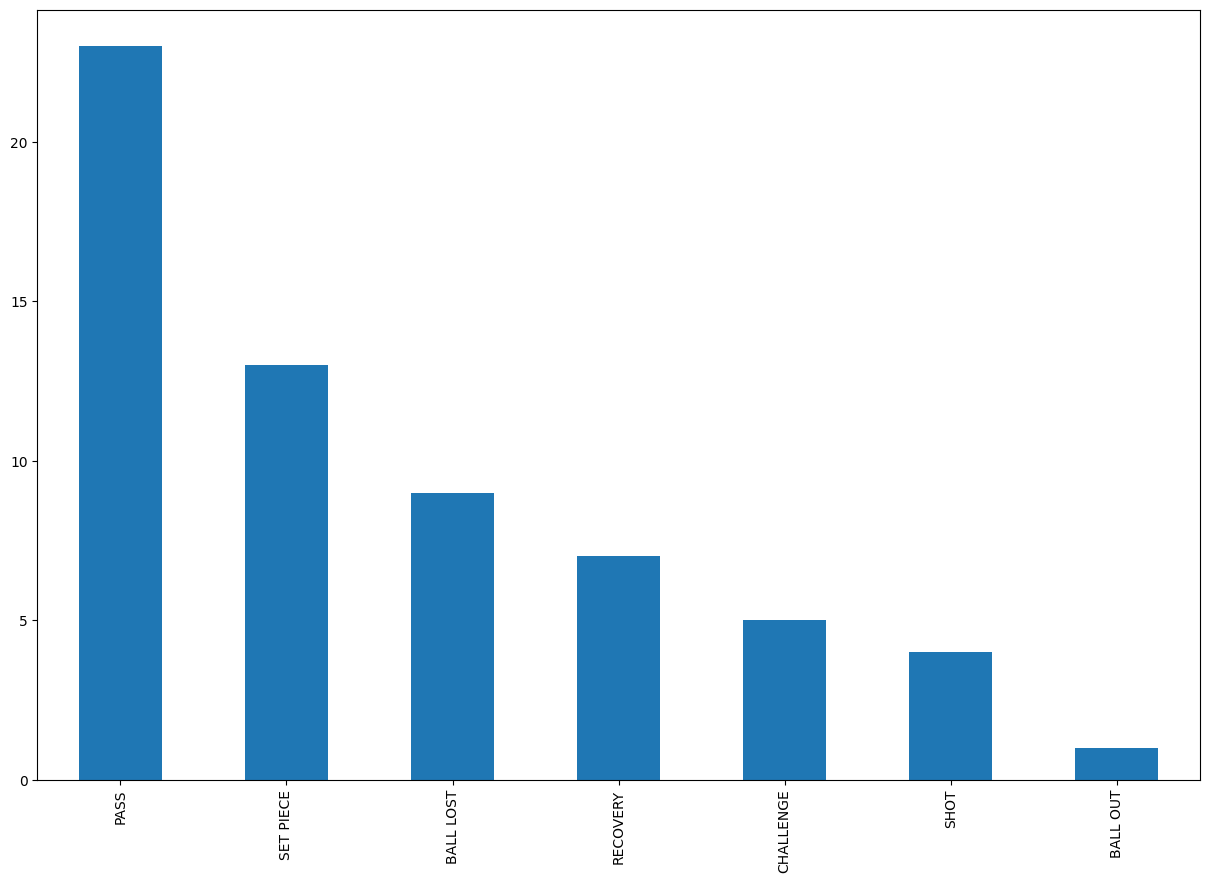

In [34]:
freq_events_4 = events[events["state"]==4]["Type"].value_counts()
print(freq_events_4)
events[events["state"]==4]["Type"].value_counts().plot.bar()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7418b957-40c0-4b8c-8b59-f82ba42a5a5a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>